In [1]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

#select the best free GPU
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 2

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

#set memory usage to 0.5
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

setGPU: Setting GPU to: 2


In [3]:
#!pip install -q keract 
import collections
import numpy
from keract import get_activations
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10 # we can use also cifar100
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.metrics
import tensorflow as tf
import time
from IPython.display import SVG

Using TensorFlow backend.


In [4]:
# LOAD DATA
num_classes = 10
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### Loading models

In [5]:
# LOAD simple MODELS
#model A: sans regularization
modelA = load_model('../models/modelA.h5')
modelA.load_weights('../models/modelA_weights_epoch50.h5')
#model B: avec regularisation
modelB = load_model('../models/modelB.h5')
modelB.load_weights('../models/modelB_weights_epoch50.h5')

In [6]:
# EVALUATION
# Final evaluation of the models
scoresA = modelA.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresA[0])
print('Test accuracy:', scoresA[1])
print("Model A CNN Error: %.2f%%" % (100-scoresA[1]*100))
scoresB = modelB.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresB[0])
print('Test accuracy:', scoresB[1])
print("Model B CNN Error: %.2f%%" % (100-scoresB[1]*100))

10000/10000 [==============================] - 2s 170us/step
Test loss: 2.342289199447632
Test accuracy: 0.6146
Model A CNN Error: 38.54%
10000/10000 [==============================] - 1s 75us/step
Test loss: 0.7456463979244232
Test accuracy: 0.7555
Model B CNN Error: 24.45%


### Mutual Information
On regarde l'information mutuelle arrondie à des binaires.

In [7]:
# On regarde l'activation des neurones pour un echantillon test
Echantillon = []
nombreDImagesDActivation = 50
NombrePairs = 10000
choix = numpy.random.choice(x_test.shape[0], nombreDImagesDActivation)
Echantillon = x_test[choix, :, : , :]

#Echantillon = [x_test[0], x_test[1], x_test[2], x_test[3], x_test[4], x_test[5], x_test[6], x_test[7], x_test[8], x_test[9], x_test[10], x_test[11], x_test[12], x_test[13]]
IMA = get_activations(modelA, Echantillon)
IMB = get_activations(modelB, Echantillon)

In [8]:
# on affiche les noms des differentes couches
print(IMA.keys())
print(IMB.keys())

dict_keys(['conv2d_3/Relu:0', 'flatten_1/Reshape:0', 'conv2d_2/Relu:0', 'dense_2/Softmax:0', 'max_pooling2d_1/MaxPool:0', 'max_pooling2d_2/MaxPool:0', 'conv2d_1/Relu:0', 'dense_1/Relu:0', 'conv2d_4/Relu:0'])
dict_keys(['flatten_2/Reshape:0', 'dropout_3/cond/Merge:0', 'dropout_1/cond/Merge:0', 'max_pooling2d_3/MaxPool:0', 'max_pooling2d_4/MaxPool:0', 'conv2d_5/Relu:0', 'conv2d_8/Relu:0', 'dense_3/Relu:0', 'conv2d_6/Relu:0', 'dense_4/Softmax:0', 'dropout_2/cond/Merge:0', 'conv2d_7/Relu:0'])


In [9]:
def MI(IM, nameOfTheLayer):
    
    #count of the number of MI = 1
    CountMI1 = 0
    #count the number of pathologic neurons (only 1 or 0)
    pathologicCount = 0
    
    #nombre d'images utilisées pour l'activation:
    numActivations = len(IM[nameOfTheLayer])
    
    #nombre de neurones dans la couche
    #numNeurons = len(IM[nameOfTheLayer][0])
    numNeurons = numpy.size(IM[nameOfTheLayer][0])
    print('number of neurons for the layer: '+str(numNeurons))

    #print(IM[nameOfTheLayer])
    #plt.imshow(IM[nameOfTheLayer])
    #plt.show()
    
    
    # on selectionne des pair de neurones (X,Y) à comparer (regarder l'information mutuelle entre X et Y)
    NeuronsSelected = numpy.zeros((NombrePairs,2))  # initialize

    for i in range(NombrePairs):
        NeuronsSelected[i] = numpy.ceil(numpy.random.rand(2)*numNeurons)  # on prend 2 neurones selectionnées aleatoirement
        # les 2 neurones doivent être différents
        while NeuronsSelected[i][0] == NeuronsSelected[i][1]:
            NeuronsSelected[i] = numpy.ceil(numpy.random.rand(2)*numNeurons)

    #print(NeuronsSelected[56])
    #print(NeuronsSelected[56][0])
    
    MutualInfo = numpy.zeros((NombrePairs,1))  # initialization des resultats

    for j in range(NombrePairs):
        X = numpy.zeros((numActivations,1))  # initialization du vecteur X
        Y = numpy.zeros((numActivations,1))  # initialization du vecteur y

        i = 0
        for activation in IM[nameOfTheLayer]:   # pour chaque element de l'echantillon (= chaque activation)
            #print(activation)
            #print(numpy.size(activation))
            activation = activation.flatten()
            #print(activation)
            X[i] = activation[int(NeuronsSelected[j][0])-1] # on regarde l'activation du neurone selectionné
            Y[i] = activation[int(NeuronsSelected[j][1])-1]

            # On binarise : RELU
            if X[i] > 0:
                X[i] = 1
            else:
                X[i] = 0
            if Y[i] > 0:
                Y[i] = 1
            else:
                Y[i] = 0

            i = i+1

        X = X.flatten()
        Y = Y.flatten()
        #print(X)
        #print(Y)

        # example:= sklearn.metrics.normalized_mutual_info_score([1.1,1.0,1.0,1.0,0.0],[1.1,0.1,0.1,1.1,0.1])
        MutualInfo[j] = sklearn.metrics.normalized_mutual_info_score(X,Y,average_method='max')
        #print(MutualInfo[j])
        if (MutualInfo[j])==1.:
            CountMI1 = CountMI1 + 1
            if all([ v == 0 for v in X ]) or all([ v == 0 for v in Y ]) or all([ v == 1 for v in X ]) or all([ v == 1 for v in Y ]):
                pathologicCount = pathologicCount + 1
            
    return MutualInfo, CountMI1, pathologicCount

number of images used for see the activations : 50

number of pairs of neurons analyzed: 10000

 Model A :

couche : conv2d_1/Relu:0
number of neurons for the layer: 32768
MI mean:  0.20015640875236781
pathologic Count:  1872  on  1879  =  99.62746141564662 %

couche : conv2d_2/Relu:0
number of neurons for the layer: 28800
MI mean:  0.05889193351829972
pathologic Count:  412  on  420  =  98.09523809523809 %

couche : max_pooling2d_1/MaxPool:0
number of neurons for the layer: 7200
MI mean:  0.02773807391443131
pathologic Count:  74  on  75  =  98.66666666666667 %

couche : conv2d_3/Relu:0
number of neurons for the layer: 14400
MI mean:  0.027797983635894388
pathologic Count:  45  on  47  =  95.74468085106383 %

couche : conv2d_4/Relu:0
number of neurons for the layer: 10816
MI mean:  0.047519844804192454
pathologic Count:  301  on  309  =  97.41100323624595 %

couche : max_pooling2d_2/MaxPool:0
number of neurons for the layer: 2304
MI mean:  0.025135953434579934
pathologic Count:  2  on

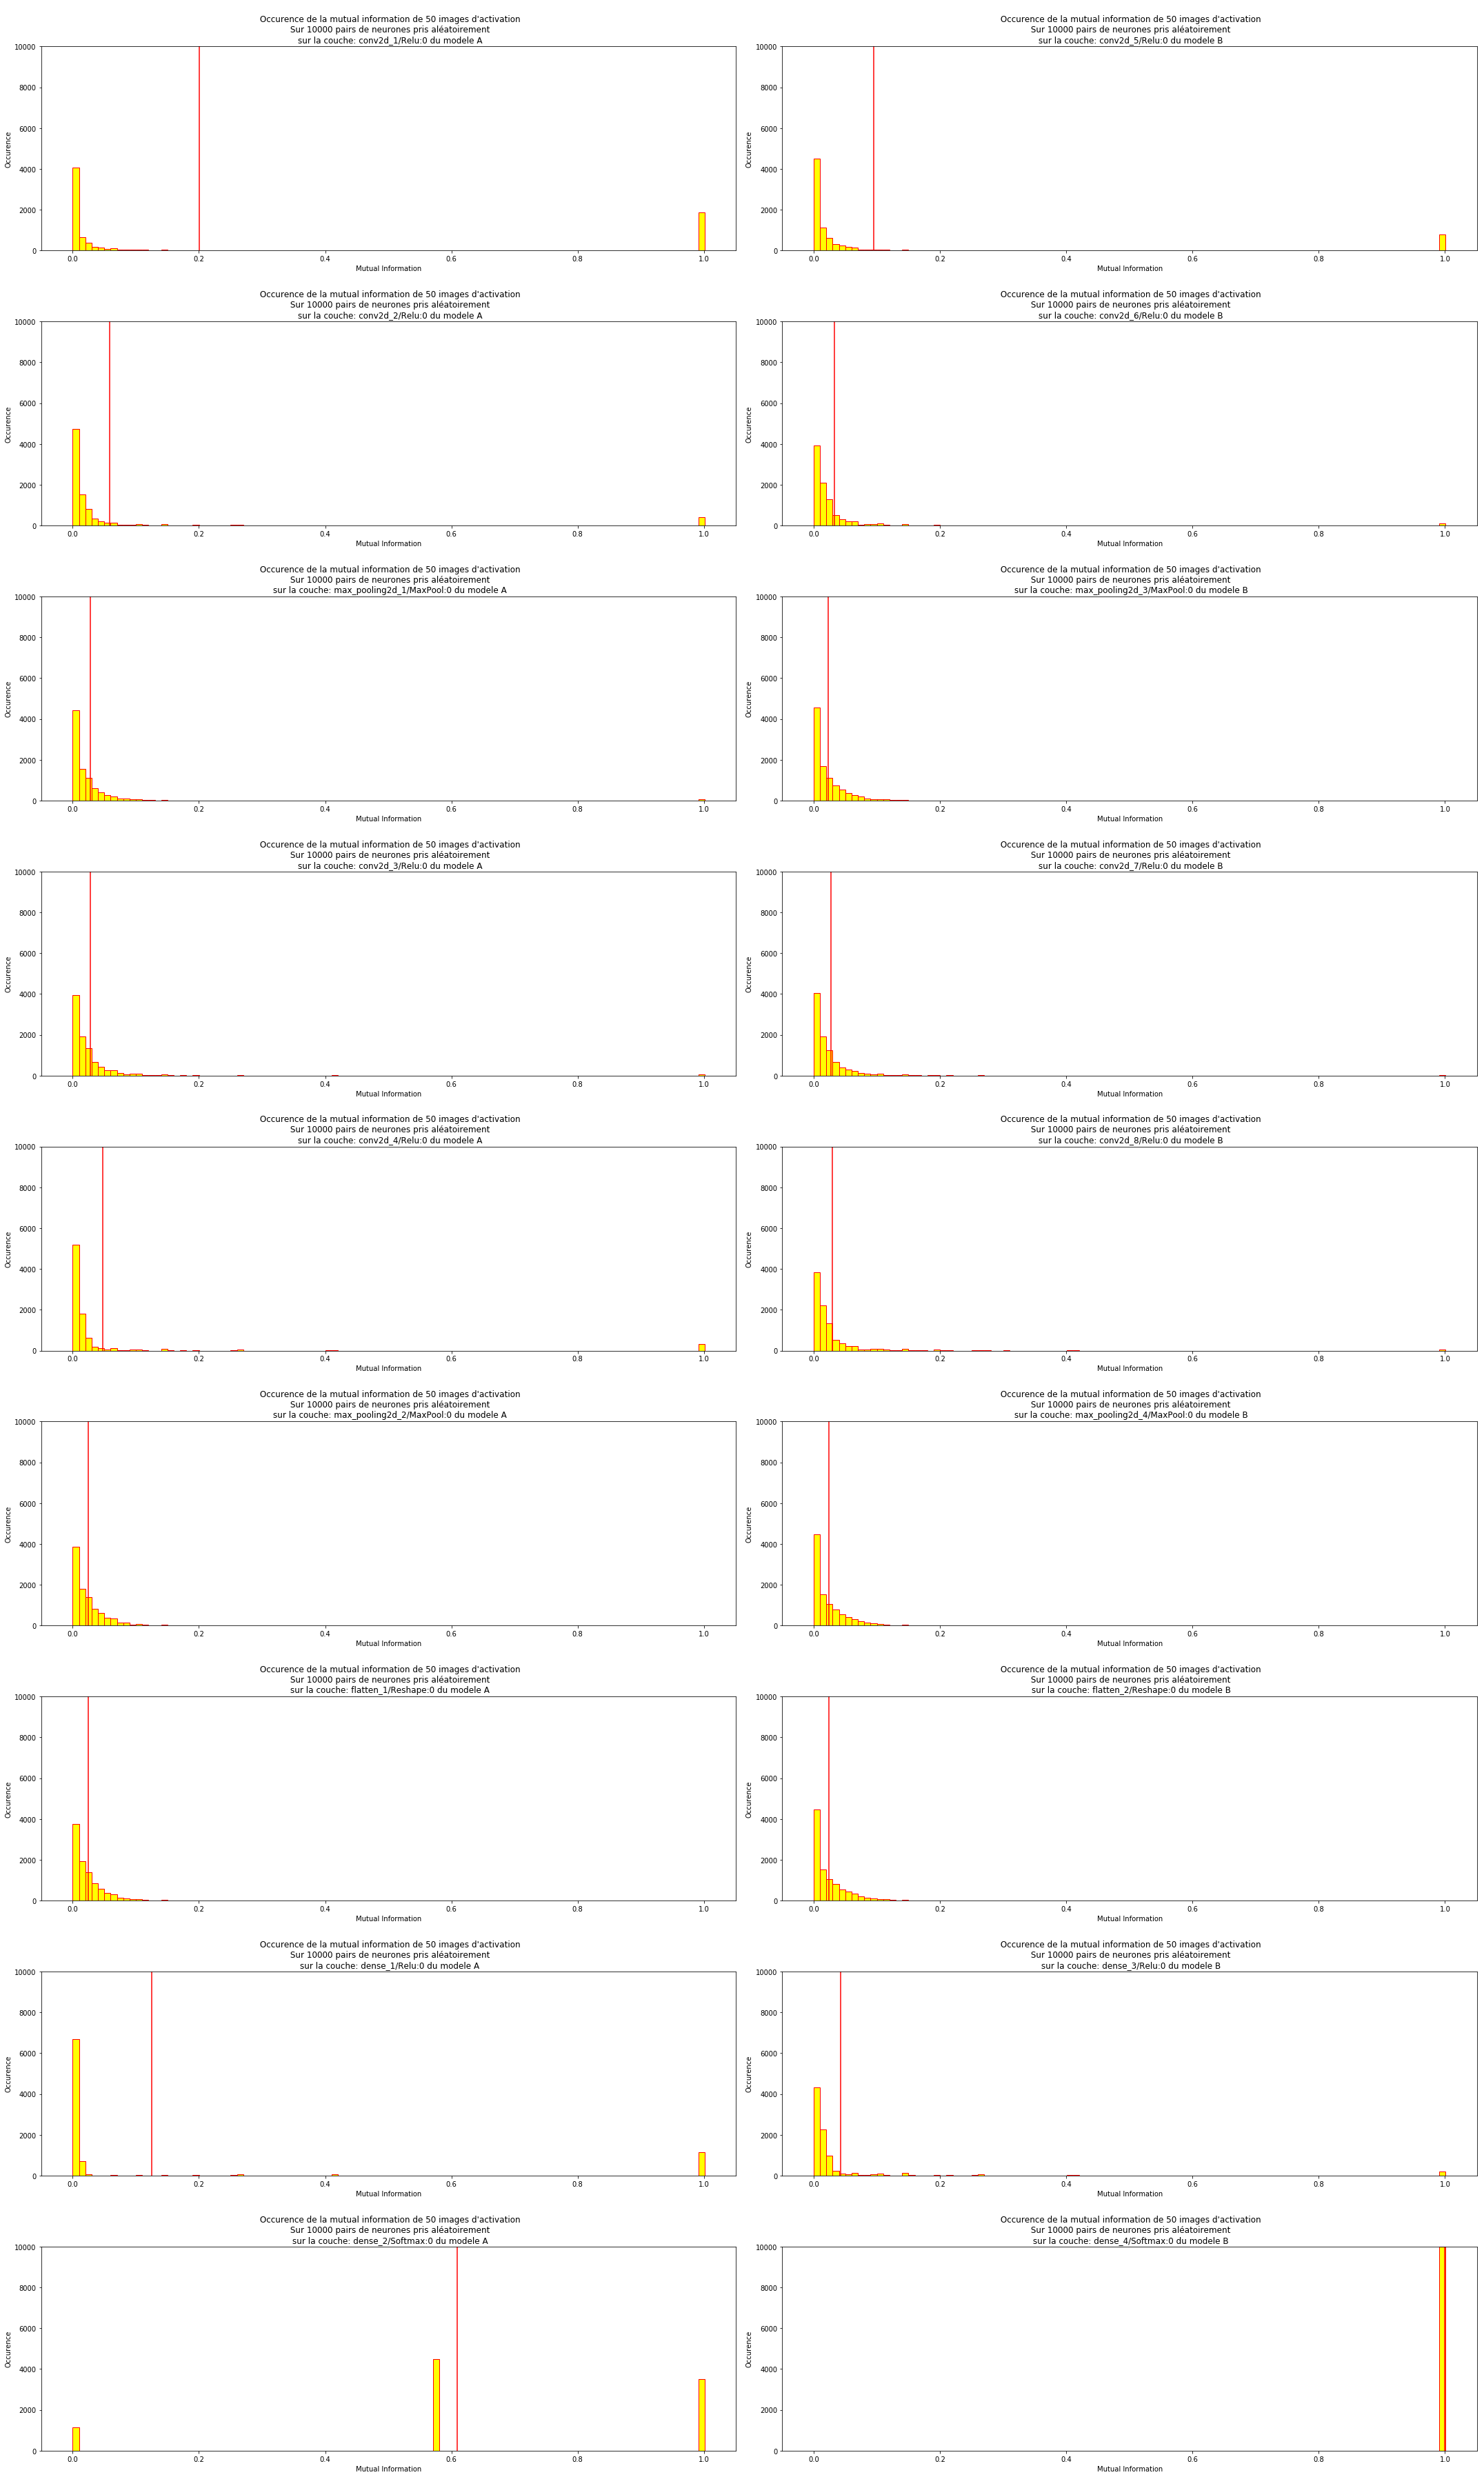

In [15]:
VarPathA = []
VarPathB = []

print('number of images used for see the activations : '+str(nombreDImagesDActivation) + '\n')
print('number of pairs of neurons analyzed: '+str(NombrePairs))

fig = plt.figure(figsize=(30, 50))
plt.ylim(top=1000)

List_of_Layers_A = ['conv2d_1/Relu:0', 'conv2d_2/Relu:0','max_pooling2d_1/MaxPool:0', 'conv2d_3/Relu:0', 'conv2d_4/Relu:0', 'max_pooling2d_2/MaxPool:0', 'flatten_1/Reshape:0', 'dense_1/Relu:0', 'dense_2/Softmax:0']
List_of_Layers_B = ['conv2d_5/Relu:0', 'conv2d_6/Relu:0','max_pooling2d_3/MaxPool:0', 'conv2d_7/Relu:0', 'conv2d_8/Relu:0', 'max_pooling2d_4/MaxPool:0', 'flatten_2/Reshape:0', 'dense_3/Relu:0', 'dense_4/Softmax:0']


# model A sans generalisation a gauche
print('\n Model A :\n')
i = 1
for layer in List_of_Layers_A:
    #nom de la couche
    print('couche :', str(layer))
    #MI
    MutualInfo, CountMI1, pathologicCount = MI(IMA, layer)
    #plot
    plt.subplot(len(IMA), 2, i)
    plt.hist(MutualInfo, range = (0, 1.001), bins = 100, color = 'yellow',
            edgecolor = 'red')
    plt.xlabel('Mutual Information')
    plt.ylabel('Occurence')
    plt.title('\n Occurence de la mutual information de '+str(nombreDImagesDActivation)+' images d\'activation\n Sur '+str(NombrePairs)+' pairs de neurones pris aléatoirement\n sur la couche: '+ str(layer)+' du modele A')
    plt.tight_layout()
    plt.ylim(top=NombrePairs)
    plt.axvline(x=numpy.mean(MutualInfo), color='red')
    MutualInfoWithoutOnes = MutualInfo.copy()
    try:
        MutualInfoWithoutOnes.tolist().remove([1.0])
    except ValueError as e:
        print(e)
        pass
    #plt.axvline(x=numpy.mean(MutualInfoWithoutOnes), color='blue')
    print('MI mean: ', str(numpy.mean(MutualInfo)))
    if CountMI1 != 0:
        VarPathA.append(pathologicCount/CountMI1)
    else:
        VarPathA.append(0)
    print('pathologic Count: ', str(pathologicCount),' on ',str(CountMI1),' = ',str(VarPathA[-1]*100),'%\n')
    i = i + 2

# model B avec generalisation a droite
print('\n Model B :\n')
i = 2
for layer in List_of_Layers_B:
    #nom de la couche
    print('couche :', str(layer))
    if "dropout" not in str(layer): 
        #MI
        MutualInfo, CountMI1, pathologicCount = MI(IMB, layer)
        #plot
        plt.subplot(len(IMA), 2, i)
        plt.hist(MutualInfo, range = (0, 1.001), bins = 100, color = 'yellow',
            edgecolor = 'red')
        plt.xlabel('Mutual Information')
        plt.ylabel('Occurence')
        plt.title('\n Occurence de la mutual information de '+str(nombreDImagesDActivation)+' images d\'activation\n Sur '+str(NombrePairs)+' pairs de neurones pris aléatoirement\n sur la couche: '+ str(layer)+' du modele B')
        plt.tight_layout()
        plt.ylim(top=NombrePairs)
        plt.axvline(x=numpy.mean(MutualInfo), color='red')
        MutualInfoWithoutOnes = MutualInfo.copy()
        try:
            MutualInfoWithoutOnes.tolist().remove([1.0])
        except ValueError as e:
            print(e)
            pass
        #plt.axvline(x=numpy.mean(MutualInfoWithoutOnes), color='blue')
        print('MI mean: ', str(numpy.mean(MutualInfo)))
        if CountMI1 != 0:
            VarPathB.append(pathologicCount/CountMI1)
        else:
            VarPathB.append(0)
        print('pathologic Count: ', str(pathologicCount),' on ',str(CountMI1),' = ',str(VarPathB[-1]*100),'%\n')
        i = i + 2
plt.show()

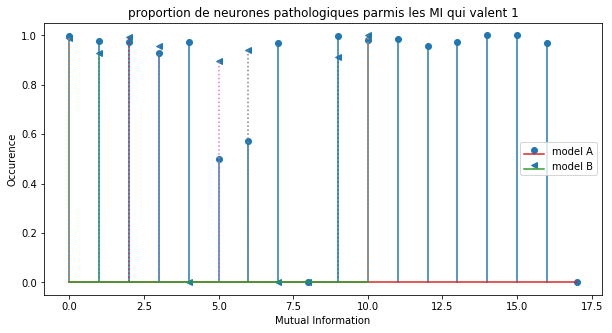

In [16]:
fig = plt.figure(figsize=(10, 5))
markerlineA, stemlinesA, baselineA = plt.stem(VarPathA)
markerlineB, stemlinesB, baselineB = plt.stem(VarPathB, linefmt=':', markerfmt="<", basefmt='C2-')
plt.legend(['model A', 'model B'])
plt.xlabel('Mutual Information')
plt.ylabel('Occurence')
plt.title('proportion de neurones pathologiques parmis les MI qui valent 1')
plt.show()

* On a donc pour les couches convolutives: + de redondances d'informations pour la premiere couche d'un NN qui generalise moins.
*   La redondance est faible pour toutes les couches au milieu, de manière assez similaire aux 2 modeles.
Pour les 2 dernieres couches denses, il y a redondance legere et moyenne pour les couches du modele qui generalise moins bien.
*    Et il y a peu de redondance et 100% pour les couches du modeles qui generalise mieux.
* -> on peut donc dire que la diversité d'information du modele qui generalise mieux est plus importante, et de plus,
    la classification se fait plus facilement (lors de la premiere couche dense #classificationLineaire??)

* ajout de la detection de neurones pathologiques: on remarque que la plupart des neurones avec une MI de 1 sont pathologiques (renvoient que des 1 ou que des 0).